In [26]:
import os
import glob
import time
import rasterio
import requests
import lacosmic
import numpy as np
import shutil
from tqdm import tqdm
from deepCR import deepCR
from rasterio.plot import show
from bs4 import BeautifulSoup as bs

In [5]:
base_dir = "/Users/Yash/Dev/CRISMIS GSoC Project/try"
base_url = "https://pdsimage2.wr.usgs.gov/archive/mess-e_v_h-mdis-2-edr-rawdata-v1.0/MSGRMDS_1001/DATA/"

In [17]:
def initialize():
    '''
    '''
    try:
        os.chdir(base_dir)
        #print(os.getcwd())
    except:
        print("Error in changing directory")
        
    data_dir = base_dir + '/retrieved_data/'
    
    if not os.path.exists(data_dir):
        try:
            os.mkdir("./retrieved_data/")
            print("Data Directory initialized")
        except:
            pass
    else:
        print("Directory \"retrieved_data\" already present !")
            
    try:
        os.chdir(data_dir)
        print(os.getcwd())
    except:
        print("Error in changing directory")

In [18]:
def downloader(url, path):
    '''
    Download helper function 
    
    Keyword arguments:
    url     -- the url to the file to download
    path    -- full path to where to save the file
    
    '''
    try:
        response = requests.get(url)
    except:
        time.sleep(2)
        response = requests.get(url)
    
    if response:
        open(path, 'wb').write(response.content)

In [19]:
def retriever(doy, *varg):  
    day_url = base_url + doy
    response = requests.get(day_url)
    data = response.text
    soup =  bs(data, 'html.parser')

    #cwd = os.getcwd()
    #print(cwd)
    work_dir = os.path.join(base_dir, 'retrieved_data', doy)
    #print(work_dir)
    
    if not os.path.exists(work_dir):
        try:
            os.mkdir(work_dir)
            print("Work Directory initialized")
        except:
            print("Directory \"" + doy + "\" already present !")  
            
    try:
        os.chdir(work_dir)
        #cwd = os.getcwd()
        #print(cwd)
    except:
        print("Error in changing directory")
    
    if not varg:
        for href in tqdm(soup.find_all('a'), "Retrieving Data"):
            link = href.get('href')
            if(link[0] not in ('?','/')):
                req_url = day_url + link
                print(link)
                #print(req_url)
                path = work_dir + link
                downloader(req_url, path)
    else:
        for arg in varg:
            req_url = day_url + arg
            print(arg)
            #print(req_url)
            path = work_dir + arg
            downloader(req_url, path)
                
    os.chdir('../')
    #cwd = os.getcwd()
    #print(cwd)

In [20]:
def retrieve_all():
    response = requests.get(base_url)
    data = response.text
    soup =  bs(data, 'html.parser')
    
    for href in tqdm(soup.find_all('a'), "Getting Links"):
        link = href.get('href')
        if(link[0] not in ('?','/')):
            print(link)
            retriever(link)

In [21]:
initialize()

Directory "retrieved_data" already present !
/Users/Yash/Dev/CRISMIS GSoC Project/try/retrieved_data


In [22]:
year = 2011
day = 207
img1 = 'EW0220137668G.IMG'
doy = str(year) + "_" + str(day) + "/"
retriever(doy, img1)

EW0220137668G.IMG


In [23]:
files = [f for f in glob.glob(base_dir + "/retrieved_data/**/*.IMG", recursive=True)]
for f in files:
    if f.find(img1) != -1:
        target = f
        break
target

'/Users/Yash/Dev/CRISMIS GSoC Project/try/retrieved_data/2011_207/EW0220137668G.IMG'

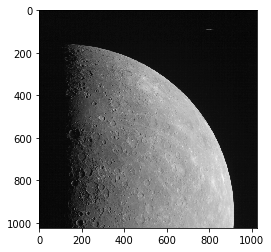

In [24]:
dataset = rasterio.open(target)
show(dataset, cmap='gray')

In [25]:
dataset.content

AttributeError: 'rasterio._io.RasterReader' object has no attribute 'content'

In [11]:
year = 2014
day = 215
img2 = 'EN1049375684M.IMG'
doy = str(year) + "_" + str(day) + "/"
retriever(doy, img2)

EN1049375684M.IMG


In [12]:
files = [f for f in glob.glob(base_dir + "/retrieved_data/**/*.IMG", recursive=True)]
for f in files:
    if f.find(img2) != -1:
        target = f
        break
target

'/Users/Yash/Dev/CRISMIS GSoC Project/try/retrieved_data/2014_215/EN1049375684M.IMG'

/Users/Yash/opt/anaconda3/envs/ml/lib/python3.7/site-packages/rasterio/__init__.py:193: UserWarning: Dataset has no geotransform set.  Default transform will be applied (Affine.identity())
  s.start()


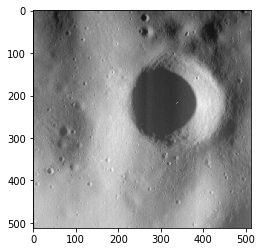

In [13]:
dataset = rasterio.open(target)
show(dataset, cmap='gray')

## The 4 cells below retrieve all the images of the following dates :

In [14]:
year = 2011
day = 207
doy = str(year) + "_" + str(day) + "/"
#retriever(doy)

In [15]:
year = 2014
day = 215
doy = str(year) + "_" + str(day) + "/"
#retriever(doy)

In [16]:
year = 2011
day = 155
doy = str(year) + "_" + str(day) + "/"
#retriever(doy)

In [17]:
year = 2011
day = 156
doy = str(year) + "_" + str(day) + "/"
#retriever(doy)

In [16]:
year = 2011
day = 157
img = "EW0215844301G.IMG"
doy = str(year) + "_" + str(day) + "/"
retriever(doy, img)

NameError: name 'retriever' is not defined

In [13]:
def identify_CRA(instance, file):
    data = rasterio.open(file)
    #show(data, cmap='gray')
    img = data.read()
    img = img * 1.0
    print(instance)
    img_arr = np.reshape(img, (img.shape[0]*img.shape[1], img.shape[2]))
    cleanarr, crmask = lacosmic.lacosmic(img_arr, contrast=5.0, cr_threshold=4.5, neighbor_threshold=0.3, 
                                         error=None, mask=None, background=None, effective_gain=1.0, 
                                         readnoise=6.5, maxiter=4, border_mode=u'mirror')
    return crmask

def searchfor(arr, val):
    for row in arr:
        for element in row:
            if element == val:
                return True
    return False

In [46]:
files = [f for f in glob.glob(base_dir + "/retrieved_data/**/*.IMG", recursive=True)]
print(len(files))
yes = []
no = []
for i, f in enumerate(files):
    crmask = identify_CRA(i, f)
    boolean = searchfor(crmask, True)
    if boolean:
        yes.append(f)
    else:
        no.append(f)
        
print(len(yes))
print(len(no))

558
0
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
1
INFO: Iteration 1: Found 124 cosmic-ray pixels, Total: 124 [lacosmic.lacosmic]
INFO: Iteration 2: Found 0 cosmic-ray pixels, Total: 124 [lacosmic.lacosmic]
2
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
3
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
4
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
5
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
6
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
7
INFO: Iteration 1: Found 3 cosmic-ray pixels, Total: 3 [lacosmic.lacosmic]
INFO: Iteration 2: Found 0 cosmic-ray pixels, Total: 3 [lacosmic.lacosmic]
8
INFO: Iteration 1: Found 1 cosmic-ray pixels, Total: 1 [lacosmic.lacosmic]
INFO: Iteration 2: Found 0 cosmic-ray pixels, Total: 1 [lacosmic.lacosmic]
9
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacos

INFO: Iteration 2: Found 0 cosmic-ray pixels, Total: 6 [lacosmic.lacosmic]
85
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
86
INFO: Iteration 1: Found 14 cosmic-ray pixels, Total: 14 [lacosmic.lacosmic]
INFO: Iteration 2: Found 0 cosmic-ray pixels, Total: 14 [lacosmic.lacosmic]
87
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
88
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
89
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
90
INFO: Iteration 1: Found 2 cosmic-ray pixels, Total: 2 [lacosmic.lacosmic]
INFO: Iteration 2: Found 0 cosmic-ray pixels, Total: 2 [lacosmic.lacosmic]
91
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
92
INFO: Iteration 1: Found 3 cosmic-ray pixels, Total: 3 [lacosmic.lacosmic]
INFO: Iteration 2: Found 0 cosmic-ray pixels, Total: 3 [lacosmic.lacosmic]
93
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacos

163
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
164
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
165
INFO: Iteration 1: Found 4 cosmic-ray pixels, Total: 4 [lacosmic.lacosmic]
INFO: Iteration 2: Found 0 cosmic-ray pixels, Total: 4 [lacosmic.lacosmic]
166
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
167
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
168
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
169
INFO: Iteration 1: Found 1 cosmic-ray pixels, Total: 1 [lacosmic.lacosmic]
INFO: Iteration 2: Found 0 cosmic-ray pixels, Total: 1 [lacosmic.lacosmic]
170
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
171
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
172
INFO: Iteration 1: Found 194 cosmic-ray pixels, Total: 194 [lacosmic.lacosmic]
INFO: Iteration 2: Found 11 cosmic-ray pixels, Total: 20

INFO: Iteration 1: Found 1006 cosmic-ray pixels, Total: 1006 [lacosmic.lacosmic]
INFO: Iteration 2: Found 94 cosmic-ray pixels, Total: 1100 [lacosmic.lacosmic]
INFO: Iteration 3: Found 6 cosmic-ray pixels, Total: 1106 [lacosmic.lacosmic]
INFO: Iteration 4: Found 0 cosmic-ray pixels, Total: 1106 [lacosmic.lacosmic]
236
INFO: Iteration 1: Found 1295 cosmic-ray pixels, Total: 1295 [lacosmic.lacosmic]
INFO: Iteration 2: Found 95 cosmic-ray pixels, Total: 1390 [lacosmic.lacosmic]
INFO: Iteration 3: Found 7 cosmic-ray pixels, Total: 1397 [lacosmic.lacosmic]
INFO: Iteration 4: Found 0 cosmic-ray pixels, Total: 1397 [lacosmic.lacosmic]
237
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
238
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
239
INFO: Iteration 1: Found 1 cosmic-ray pixels, Total: 1 [lacosmic.lacosmic]
INFO: Iteration 2: Found 0 cosmic-ray pixels, Total: 1 [lacosmic.lacosmic]
240
INFO: Iteration 1: Found 0 cosmic-ray pixels, To

311
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
312
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
313
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
314
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
315
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
316
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
317
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
318
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
319
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
320
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
321
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
322
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
323
INFO: Iteration 1: Found 0 cosmic-ray pixels, To

414
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
415
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
416
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
417
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
418
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
419
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
420
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
421
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
422
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
423
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
424
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
425
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
426
INFO: Iteration 1: Found 0 cosmic-ray pixels, To

INFO: Iteration 1: Found 1696 cosmic-ray pixels, Total: 1696 [lacosmic.lacosmic]
INFO: Iteration 2: Found 33 cosmic-ray pixels, Total: 1729 [lacosmic.lacosmic]
INFO: Iteration 3: Found 9 cosmic-ray pixels, Total: 1738 [lacosmic.lacosmic]
INFO: Iteration 4: Found 0 cosmic-ray pixels, Total: 1738 [lacosmic.lacosmic]
497
INFO: Iteration 1: Found 815 cosmic-ray pixels, Total: 815 [lacosmic.lacosmic]
INFO: Iteration 2: Found 4 cosmic-ray pixels, Total: 819 [lacosmic.lacosmic]
INFO: Iteration 3: Found 0 cosmic-ray pixels, Total: 819 [lacosmic.lacosmic]
498
INFO: Iteration 1: Found 642 cosmic-ray pixels, Total: 642 [lacosmic.lacosmic]
INFO: Iteration 2: Found 4 cosmic-ray pixels, Total: 646 [lacosmic.lacosmic]
INFO: Iteration 3: Found 0 cosmic-ray pixels, Total: 646 [lacosmic.lacosmic]
499
INFO: Iteration 1: Found 117 cosmic-ray pixels, Total: 117 [lacosmic.lacosmic]
INFO: Iteration 2: Found 0 cosmic-ray pixels, Total: 117 [lacosmic.lacosmic]
500
INFO: Iteration 1: Found 168 cosmic-ray pixels

INFO: Iteration 2: Found 22 cosmic-ray pixels, Total: 941 [lacosmic.lacosmic]
INFO: Iteration 3: Found 3 cosmic-ray pixels, Total: 944 [lacosmic.lacosmic]
INFO: Iteration 4: Found 3 cosmic-ray pixels, Total: 947 [lacosmic.lacosmic]
533
INFO: Iteration 1: Found 88 cosmic-ray pixels, Total: 88 [lacosmic.lacosmic]
INFO: Iteration 2: Found 0 cosmic-ray pixels, Total: 88 [lacosmic.lacosmic]
534
INFO: Iteration 1: Found 640 cosmic-ray pixels, Total: 640 [lacosmic.lacosmic]
INFO: Iteration 2: Found 13 cosmic-ray pixels, Total: 653 [lacosmic.lacosmic]
INFO: Iteration 3: Found 0 cosmic-ray pixels, Total: 653 [lacosmic.lacosmic]
535
INFO: Iteration 1: Found 363 cosmic-ray pixels, Total: 363 [lacosmic.lacosmic]
INFO: Iteration 2: Found 9 cosmic-ray pixels, Total: 372 [lacosmic.lacosmic]
INFO: Iteration 3: Found 9 cosmic-ray pixels, Total: 381 [lacosmic.lacosmic]
INFO: Iteration 4: Found 8 cosmic-ray pixels, Total: 389 [lacosmic.lacosmic]
536
INFO: Iteration 1: Found 737 cosmic-ray pixels, Total: 

Images having Cosmic Ray Artifacts


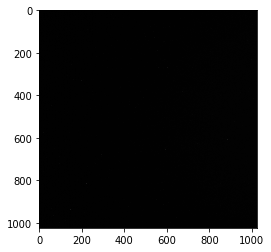

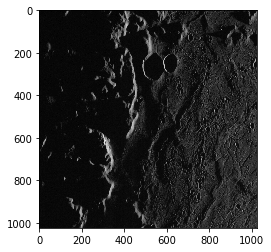

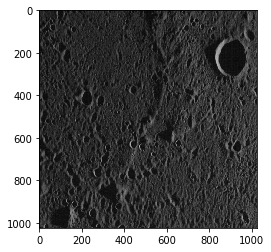

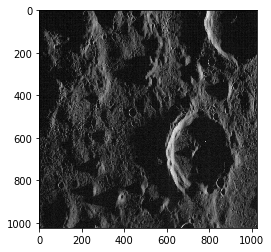

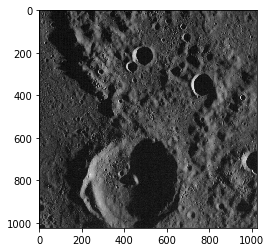

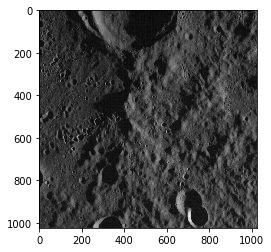

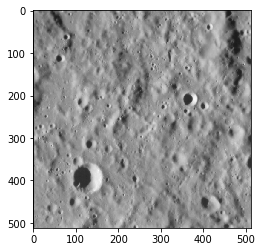

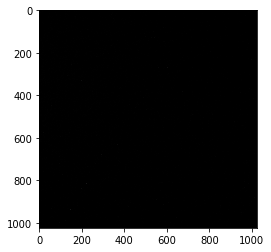

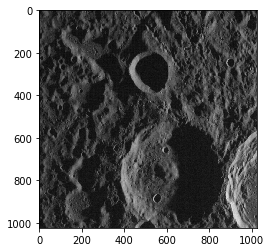

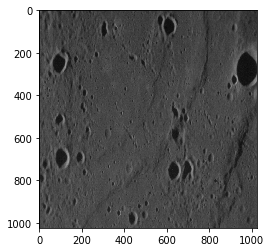

In [47]:
print("Images having Cosmic Ray Artifacts")
for f in yes[:10]:
    data = rasterio.open(f)
    show(data, cmap='gray')

Images NOT having Cosmic Ray Artifacts


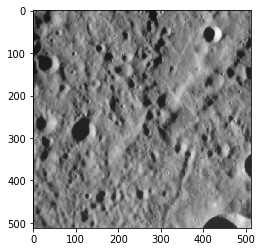

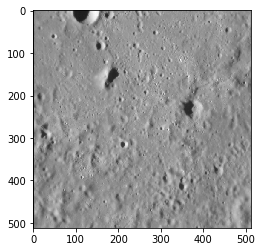

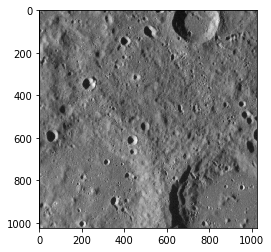

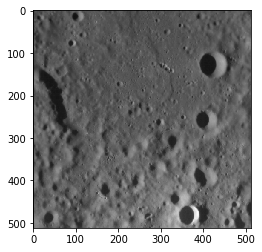

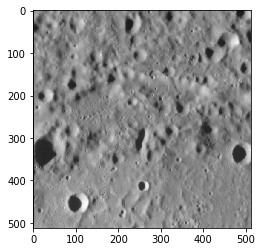

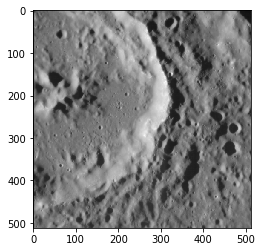

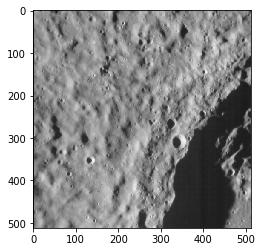

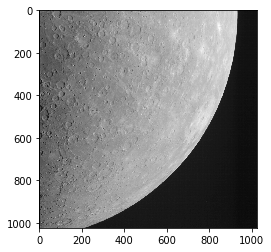

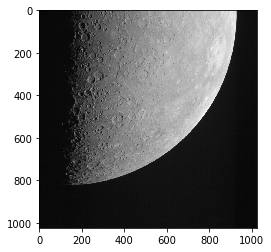

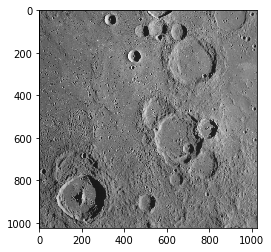

In [48]:
print("Images NOT having Cosmic Ray Artifacts")
for f in no[:10]:
    data = rasterio.open(f)
    show(data, cmap='gray')

In [30]:
def identify_CRA(instance, file):
    data = rasterio.open(file)
    #show(data, cmap='gray')
    img = data.read()
    img = img * 1.0
    print(instance)
    img_arr = np.reshape(img, (img.shape[0]*img.shape[1], img.shape[2]))
    cleanarr, crmask = lacosmic.lacosmic(img_arr, contrast=5.0, cr_threshold=4.5, neighbor_threshold=0.3, 
                                         error=None, mask=None, background=None, effective_gain=1.0, 
                                         readnoise=6.5, maxiter=4, border_mode=u'mirror')
    return crmask

def searchfor(arr, val=True):
    for row in arr:
        for element in row:
            if element == val:
                return True
    return False

In [31]:
files = [base_dir + "/retrieved_data/2011_207/EW0220137668G.IMG", 
        base_dir + "/retrieved_data/2011_155/EW0215651174C.IMG",
        base_dir + "/retrieved_data/2014_215/EN1049375684M.IMG",
        base_dir + "/retrieved_data/2011_156/EN0215728629M.IMG",
        base_dir + "/retrieved_data/2011_156/EW0215726557D.IMG",
        base_dir + "/retrieved_data/2011_157/EW0215844301G.IMG",]

print(len(files))

yes = []
no = []

present = os.path.join(base_dir, 'present')
absent = os.path.join(base_dir, 'absent')

for i, f in enumerate(files):
    crmask = identify_CRA(i, f)
    boolean = searchfor(crmask)
    if boolean:
        yes.append(f)
        destination = os.path.join(present, f[f.rfind('/')+1:])
        try:
            shutil.copy(f, destination)
        except Exception as e:
            print(e)
    else:
        no.append(f)
        try:
            destination = os.path.join(absent, f[f.rfind('/')+1:])
            shutil.copy(f, destination)
        except Exception as e:
            print(e)
        
print(len(yes))
print(len(no))

6
0
INFO: Iteration 1: Found 14 cosmic-ray pixels, Total: 14 [lacosmic.lacosmic]
INFO: Iteration 2: Found 0 cosmic-ray pixels, Total: 14 [lacosmic.lacosmic]
1
INFO: Iteration 1: Found 10 cosmic-ray pixels, Total: 10 [lacosmic.lacosmic]
INFO: Iteration 2: Found 0 cosmic-ray pixels, Total: 10 [lacosmic.lacosmic]
2
INFO: Iteration 1: Found 0 cosmic-ray pixels, Total: 0 [lacosmic.lacosmic]
3
INFO: Iteration 1: Found 601 cosmic-ray pixels, Total: 601 [lacosmic.lacosmic]
INFO: Iteration 2: Found 11 cosmic-ray pixels, Total: 612 [lacosmic.lacosmic]
INFO: Iteration 3: Found 0 cosmic-ray pixels, Total: 612 [lacosmic.lacosmic]
4
INFO: Iteration 1: Found 653 cosmic-ray pixels, Total: 653 [lacosmic.lacosmic]
INFO: Iteration 2: Found 2 cosmic-ray pixels, Total: 655 [lacosmic.lacosmic]
INFO: Iteration 3: Found 0 cosmic-ray pixels, Total: 655 [lacosmic.lacosmic]
5
INFO: Iteration 1: Found 19 cosmic-ray pixels, Total: 19 [lacosmic.lacosmic]
INFO: Iteration 2: Found 0 cosmic-ray pixels, Total: 19 [laco

Images having Cosmic Ray Artifacts
Input Image : EW0220137668G.IMG


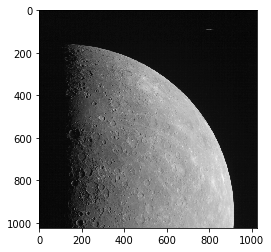

Input Image : EW0215651174C.IMG


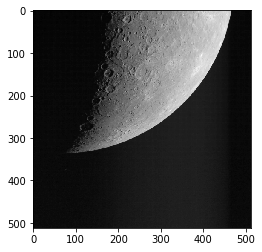

Input Image : EN0215728629M.IMG


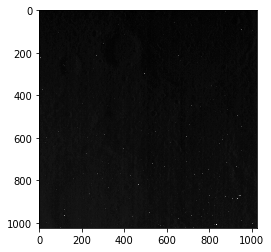

Input Image : EW0215726557D.IMG


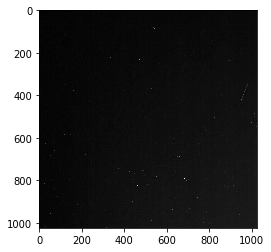

Input Image : EW0215844301G.IMG


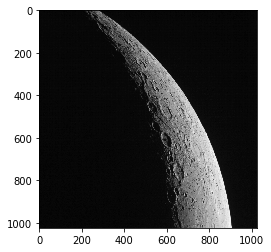

In [32]:
print("Images having Cosmic Ray Artifacts")
for f in yes[:10]:
    print("Input Image : " + f[f.rfind('/')+1:])
    data = rasterio.open(f)
    show(data, cmap='gray')
    

Images NOT having Cosmic Ray Artifacts


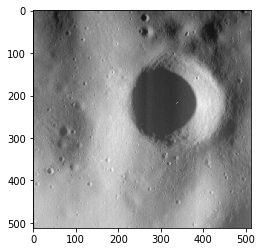

NameError: name 'p' is not defined

In [33]:
print("Images NOT having Cosmic Ray Artifacts")
for f in no[:10]:
    data = rasterio.open(f)
    show(data, cmap='gray')
    (p[p.rfind('/')+1:])

In [ ]:
def make_dataset():
  
    present = os.path.join(base_dir, 'present')
    absent = os.path.join(base_dir, 'absent')
    
    if not os.path.exists(present):
        try:
            os.mkdir(present)
            print("Present Directory initialized")
        except:
            print("Directory \"Present\" already present !")
    
    if not os.path.exists(absent):
        try:
            os.mkdir(absent)
            print("Absent Directory initialized")
        except:
            print("Directory \"Absent\" already present !")
        